## Homework 4

Laszlo Tetenyi

In [1]:
#Packages
%matplotlib inline 
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [2]:
# Initialization - needed for the plots
n_max=500 #The maximum number of length of x_t
n_break=10 # Breakpoints for simulation and estimation

In [3]:
#Attempt 1 - avoid matrix inversion
def AR1bias(alpha):
    #Initialization
    sigma=1.0
    mu=0.0
    beta=0.0
    simusize=10000
    # Draw the shocks and fix them for n_max
    Eps=sigma*np.random.standard_normal((simusize,n_max))+mu
    X=np.empty((simusize,n_max+1))
    # Fill the first row with the stationary X
    X[:,0]=np.ones((simusize)) * (beta/(1-alpha))
    #Instead of doing OLS after getting the data, better to use summing in the for-loop as we can vectorize
    x_mean=np.empty((n_break,simusize))
    x_prevmean=np.empty((n_break,simusize))
    x_cov=np.empty((n_break,simusize))
    x_var=np.empty((n_break,simusize))
    alpha_simu=np.empty((n_break,simusize))
    alpha_avg=np.empty((n_break,1))
    for i in range(n_max):
        X[:,i+1]=alpha*X[:,i] + beta + Eps[:,i]
        #if (i % (n_max/n_break) ==(n_max/n_break-1)): # the for loop is faster - this might depend on n_break
            #t=int((i-(n_max/n_break-1))/((n_max/n_break)))
            #x_mean[t,:]=np.mean(X[:,1:(i+1)],1)
            #x_prevmean[t,:] =np.mean(X[:,0:i],1)
            #x_cov[t,:]=np.sum(np.multiply((X[:,1:(i+1)].transpose()-x_mean[t,:].transpose()).transpose(),(X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose()),1)
            #x_var[t,:]=np.sum(np.multiply((X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose(),(X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose()),1)
            #alpha_simu[t,:] = np.multiply(x_cov[t,:], 1/x_var[t,:])
            #alpha_avg[t]= np.mean(alpha_simu[t,:])
    for t in range(n_break):
        i=t*(50)+50
        x_mean[t,:]=np.mean(X[:,1:(i+1)],1)
        x_prevmean[t,:] =np.mean(X[:,0:i],1)
        x_cov[t,:]=np.sum(np.multiply((X[:,1:(i+1)].transpose()-x_mean[t,:].transpose()).transpose(),(X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose()),1)
        x_var[t,:]=np.sum(np.multiply((X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose(),(X[:,0:(i)].transpose()-x_prevmean[t,:].transpose()).transpose()),1)
        alpha_simu[t,:] = np.multiply(x_cov[t,:], 1/x_var[t,:])
        alpha_avg[t]= np.mean(alpha_simu[t,:])
    return alpha_avg-alpha

In [4]:
timeit AR1bias(0.5)

1 loops, best of 3: 3.56 s per loop


In [5]:
AR1bias_numba=jit(AR1bias)

In [6]:
timeit AR1bias_numba(0.5) # Jitting doesnt help - cython? I am using numpy too much

The slowest run took 5.22 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 2.7 s per loop


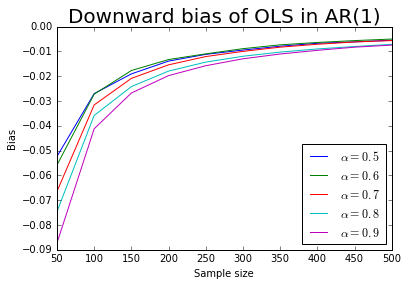

In [7]:
alpha_grid=np.linspace(0.5,0.9,5)
n_grid=np.linspace(n_max/n_break,n_max,n_break)
for i in range(alpha_grid.size):
    #string= 'alpha= %s' %alpha_grid[i]
    plot=plt.plot(n_grid,AR1bias(alpha_grid[i]),label=r'$\alpha= %s$' %alpha_grid[i])
    plt.legend(loc=4)
    #plt.legend(plot,r'$\alpha=$')
plt.xlabel('Sample size')
plt.ylabel('Bias')
plt.title('Downward bias of OLS in AR(1)', fontsize=20)
plt.show()
#Bias increases with the AR coefficient

In [8]:
#Attempt 2 - avoid summing
def AR1bias_reg(alpha):
    #Initialization
    sigma=1.0
    mu=0.0
    beta=0.0
    simusize=1000
    from scipy.stats import linregress
    # Draw the shocks and fix them for n_max
    Eps=sigma*np.random.standard_normal((simusize,n_max))+mu
    X=np.empty((simusize,n_max+1))
    # Fill the first row with the stationary X
    X[:,0]=np.ones((simusize)) * (beta/(1-alpha))
    alpha_simu=np.empty((n_break,simusize))
    alpha_avg=np.empty((n_break,1))
    for i in range(n_max):
        X[:,i+1]=alpha*X[:,i] + beta + Eps[:,i]
        if (i % (n_max/n_break) ==(n_max/n_break-1)):
            t=int((i-(n_max/n_break-1))/((n_max/n_break)))
            for j in range(simusize):
                slope, intercept, r_value, p_value, std_err = linregress(X[j,0:i],X[j,1:(i+1)])
                alpha_simu[t,j] = slope
            alpha_avg[t]= np.mean(alpha_simu[t,:])
    return alpha_avg-alpha

In [9]:
timeit AR1bias_reg(0.5) # It is superslow for even 1000 simulations - attempt 1 is faster

1 loops, best of 3: 22 s per loop
